In [10]:
import sqlite3
import pandas as pd
import os
from sqlite3 import connect
import matplotlib.pyplot as plt
import torch
import transformers
import pysentimiento
from pysentimiento import create_analyzer
import os
import pickle

In [11]:
def load_data(database_file):
    conn = sqlite3.connect(database_file)
    authors_table = 'authors'
    posts_table = 'posts'
    posts_query = "SELECT * FROM posts"  
    authors_query = "SELECT * FROM authors"  
    tweets_df = pd.read_sql_query(posts_query, conn)
    authors_df = pd.read_sql_query(authors_query, conn)
    conn.close()
    print(f"Loaded {len(tweets_df)} rows from posts and {len(authors_df)} rows from authors.")
    return tweets_df, authors_df

In [12]:
def preprocess_data(tweets_df, authors_df):
    """Filter and preprocess the data."""
    filtered = authors_df['author_screen_name']
    tweets_df = tweets_df[tweets_df['author'].isin(filtered)]
    return tweets_df

In [13]:
def parse_date(date_str):
    try:
        # Try parsing with four-digit year first
        return pd.to_datetime(date_str, format='%Y-%m-%d')
    except ValueError:
        # If it fails, try parsing with two-digit year
        return pd.to_datetime(date_str, format='%y-%m-%d')

In [14]:
import re

def clean_text(text):
    if not isinstance(text, str):
        print("Invalid text input:", text)
        return ""
   
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s,.;!?-]', '', text)
    text = text.lower()
    return text



# Emotions model


In [15]:
def process_tweets(
    tweets_df,
    output_file,
    checkpoint_file,
    batch_size=1000,
    max_batches=80,
    lang="en",
    task="emotion"
):
    """
    Processes tweets for analysis using a specified task and language model.
    
    Parameters:
        tweets_df (pd.DataFrame): DataFrame containing tweets. Must include 'content', 'author', and 'new_date' columns.
        output_file (str): Path to save the output file with analysis results.
        checkpoint_file (str): Path to save the checkpoint file for resuming progress.
        batch_size (int): Number of tweets to process in each batch. Default is 1000.
        max_batches (int): Maximum number of batches to process. Default is None (process all).
        lang (str): Language for the analysis model. Default is "en".
        task (str): Analysis task for the model (e.g., "emotion", "sentiment"). Default is "emotion".
    """
    # Set logging level for transformers
    transformers.logging.set_verbosity(transformers.logging.ERROR)

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the analyzer for the specified task
    analyzer = create_analyzer(task=task, lang=lang)

    # Move the model to GPU if available
    analyzer.model.to(device)

    # Load checkpoint if it exists
    start_index = 0
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            start_index = pickle.load(f)
        print(f"Resuming from index: {start_index}")
    else:
        print("Starting from the beginning (index 0).")

    # Results container
    results = []

    # Process tweets in batches
    for batch_number, i in enumerate(range(start_index, len(tweets_df), batch_size)):
        if max_batches is not None and batch_number >= max_batches:
            print(f"Reached the limit of {max_batches} batches. Stopping.")
            break

        batch = tweets_df.iloc[i:i + batch_size]  # Select batch of tweets

        for _, tweet in batch.iterrows():
            content = tweet['content']
            if content:
                # Perform analysis
                analysis_result = analyzer.predict(content)

                # Extract probabilities or outputs dynamically
                probabilities = analysis_result.probas if hasattr(analysis_result, "probas") else analysis_result.output
                formatted_probabilities = {k: f"{v:.3f}" for k, v in probabilities.items()}

                results.append({
                    'author': tweet['author'],
                    'new_date': tweet['new_date'],
                    'content': content,
                    **formatted_probabilities,
                })

        # Save results periodically
        if results:
            df = pd.DataFrame(results)
            df.to_csv(output_file, sep='\t', index=False, mode='a', header=not os.path.exists(output_file))
            results = []  # Clear results after saving

        # Save checkpoint
        with open(checkpoint_file, 'wb') as f:
            pickle.dump(i + batch_size, f)

        print(f"Processed batch {batch_number + 1}")

    # Save remaining results
    if results:
        df = pd.DataFrame(results)
        df.to_csv(output_file, sep='\t', index=False, mode='a', header=not os.path.exists(output_file))

    # Final checkpoint update
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(len(tweets_df), f)

    print("All tweets have been processed and saved.")


# Results

# Visual Representation 


In [16]:
def calculate_monthly_author_means(df, task_columns):
    """
    Calculate the monthly mean values for the specified task columns per author.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'author', 'new_date', and task-specific columns.
        task_columns (list): A list of columns related to the task (e.g., emotion or sentiment scores).

    Returns:
        pd.DataFrame: A DataFrame with monthly mean values per author for the specified task columns.
    """
    # Convert new_date to datetime if not already
    df['new_date'] = pd.to_datetime(df['new_date'])
    
    # Extract year-month for grouping
    df['year_month'] = df['new_date'].dt.to_period('M')
    
    # Prepare the aggregation dictionary dynamically
    agg_dict = {col: 'mean' for col in task_columns}
    
    # Calculate mean values per author per month
    monthly_author_means = df.groupby(['author', 'year_month']).agg(agg_dict).reset_index()
    
    return monthly_author_means



In [17]:
def calculate_mean_over_time(df, group_by_column, date_column, task_columns):
    """
    Calculate mean probabilities over time for specified task columns.

    Args:
        df (pd.DataFrame): DataFrame containing the data to analyze.
        group_by_column (str): Column name to group by (e.g., 'author').
        date_column (str): Column name containing date information.
        task_columns (list): List of task-specific columns to calculate mean values for.

    Returns:
        pd.DataFrame: A DataFrame with mean probabilities for each date and group.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract year-month for grouping
    df['year_month'] = df[date_column].dt.to_period('M')
    
    # Aggregate task columns and calculate mean values grouped by author and year_month
    agg_dict = {col: 'mean' for col in task_columns}
    mean_over_time = df.groupby([group_by_column, 'year_month']).agg(agg_dict).reset_index()
    
    return mean_over_time


In [18]:
def calculate_mean_of_means(monthly_author_means, task_columns):
    """
    Calculate the mean of the task-specific columns across all authors for each month.

    Args:
        monthly_author_means (pd.DataFrame): DataFrame containing aggregated task-specific columns per author per month.
        task_columns (list): A list of task-specific columns to calculate the mean of means.

    Returns:
        pd.DataFrame: A DataFrame with monthly mean values for the specified task columns.
    """
    # Prepare the aggregation dictionary dynamically
    agg_dict = {col: 'mean' for col in task_columns}
    
    # Calculate mean of each task column across all authors for each month
    monthly_means = monthly_author_means.groupby('year_month').agg(agg_dict).reset_index()
    
    return monthly_means


# Example usage
# second_mean_nurses = calculate_mean_of_means(first_mean_nurses)
# second_mean_doctors = calculate_mean_of_means(first_mean_doctors)

In [19]:
import matplotlib.pyplot as plt

def plot_trends(group_dataframes, task_columns, group_names, save_dir=None):
    """
    Plot trends for task-specific columns for multiple social groups and save as PNG files.

    Args:
        group_dataframes (list): A list of DataFrames, each representing a social group.
        task_columns (list): A list of task-specific columns to plot.
        group_names (list): A list of names corresponding to each DataFrame in group_dataframes.
        save_dir (str, optional): Directory to save the plots. If None, plots will not be saved.

    Returns:
        None
    """
    # Convert year_month to datetime for plotting in all DataFrames
    for df in group_dataframes:
        df['year_month'] = df['year_month'].dt.to_timestamp()

    # Set up subplots for each task-specific column
    num_plots = len(task_columns)
    plt.figure(figsize=(15, num_plots * 3))  # Adjust height based on number of plots

    for idx, column in enumerate(task_columns, 1):
        plt.subplot((num_plots + 1) // 2, 2, idx)  # Arrange plots in 2 columns

        for df, group_name in zip(group_dataframes, group_names):
            plt.plot(df['year_month'], df[column], label=f'{column.capitalize()} - {group_name}')
        
        # Add title, labels, and legend
        plt.title(f'{column.capitalize()} Trend Over Time')
        plt.xlabel('Year-Month')
        plt.ylabel('Probability')
        plt.legend()
        plt.grid(True)

    # Save the entire figure if save_dir is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "trends_plot.png")
        plt.savefig(save_path, format='png', bbox_inches='tight')
        print(f"Plot saved as: {save_path}")

    plt.tight_layout()
    plt.show()


Loading data from database...
Loaded 27215547 rows from posts and 53063 rows from authors.
Preprocessing data...
Cleaning text data...
Invalid text input: None
Invalid text input: None
Invalid text input: None
Invalid text input: None
Parsing dates...
Processing tweets for emotion...
Using device: cuda
Starting from the beginning (index 0).
Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Reached the limit of 10 batches. Stopping.
All tweets have been processed and saved.
Analyzing emotion...
Processing tweets for sentiment...
Using device: cuda
Starting from the beginning (index 0).
Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Reached the limit of 10 batches. Stopping.
All tweets have been processed and saved.
Analyzing s

/tmp/ipykernel_2620818/658242755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_date'] = pd.to_datetime(df['new_date'])
/tmp/ipykernel_2620818/658242755.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['new_date'].dt.to_period('M')
/tmp/ipykernel_2620818/658242755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Plot saved as: output_analysis2/emotion_analysis_graphs/trends_plot.png


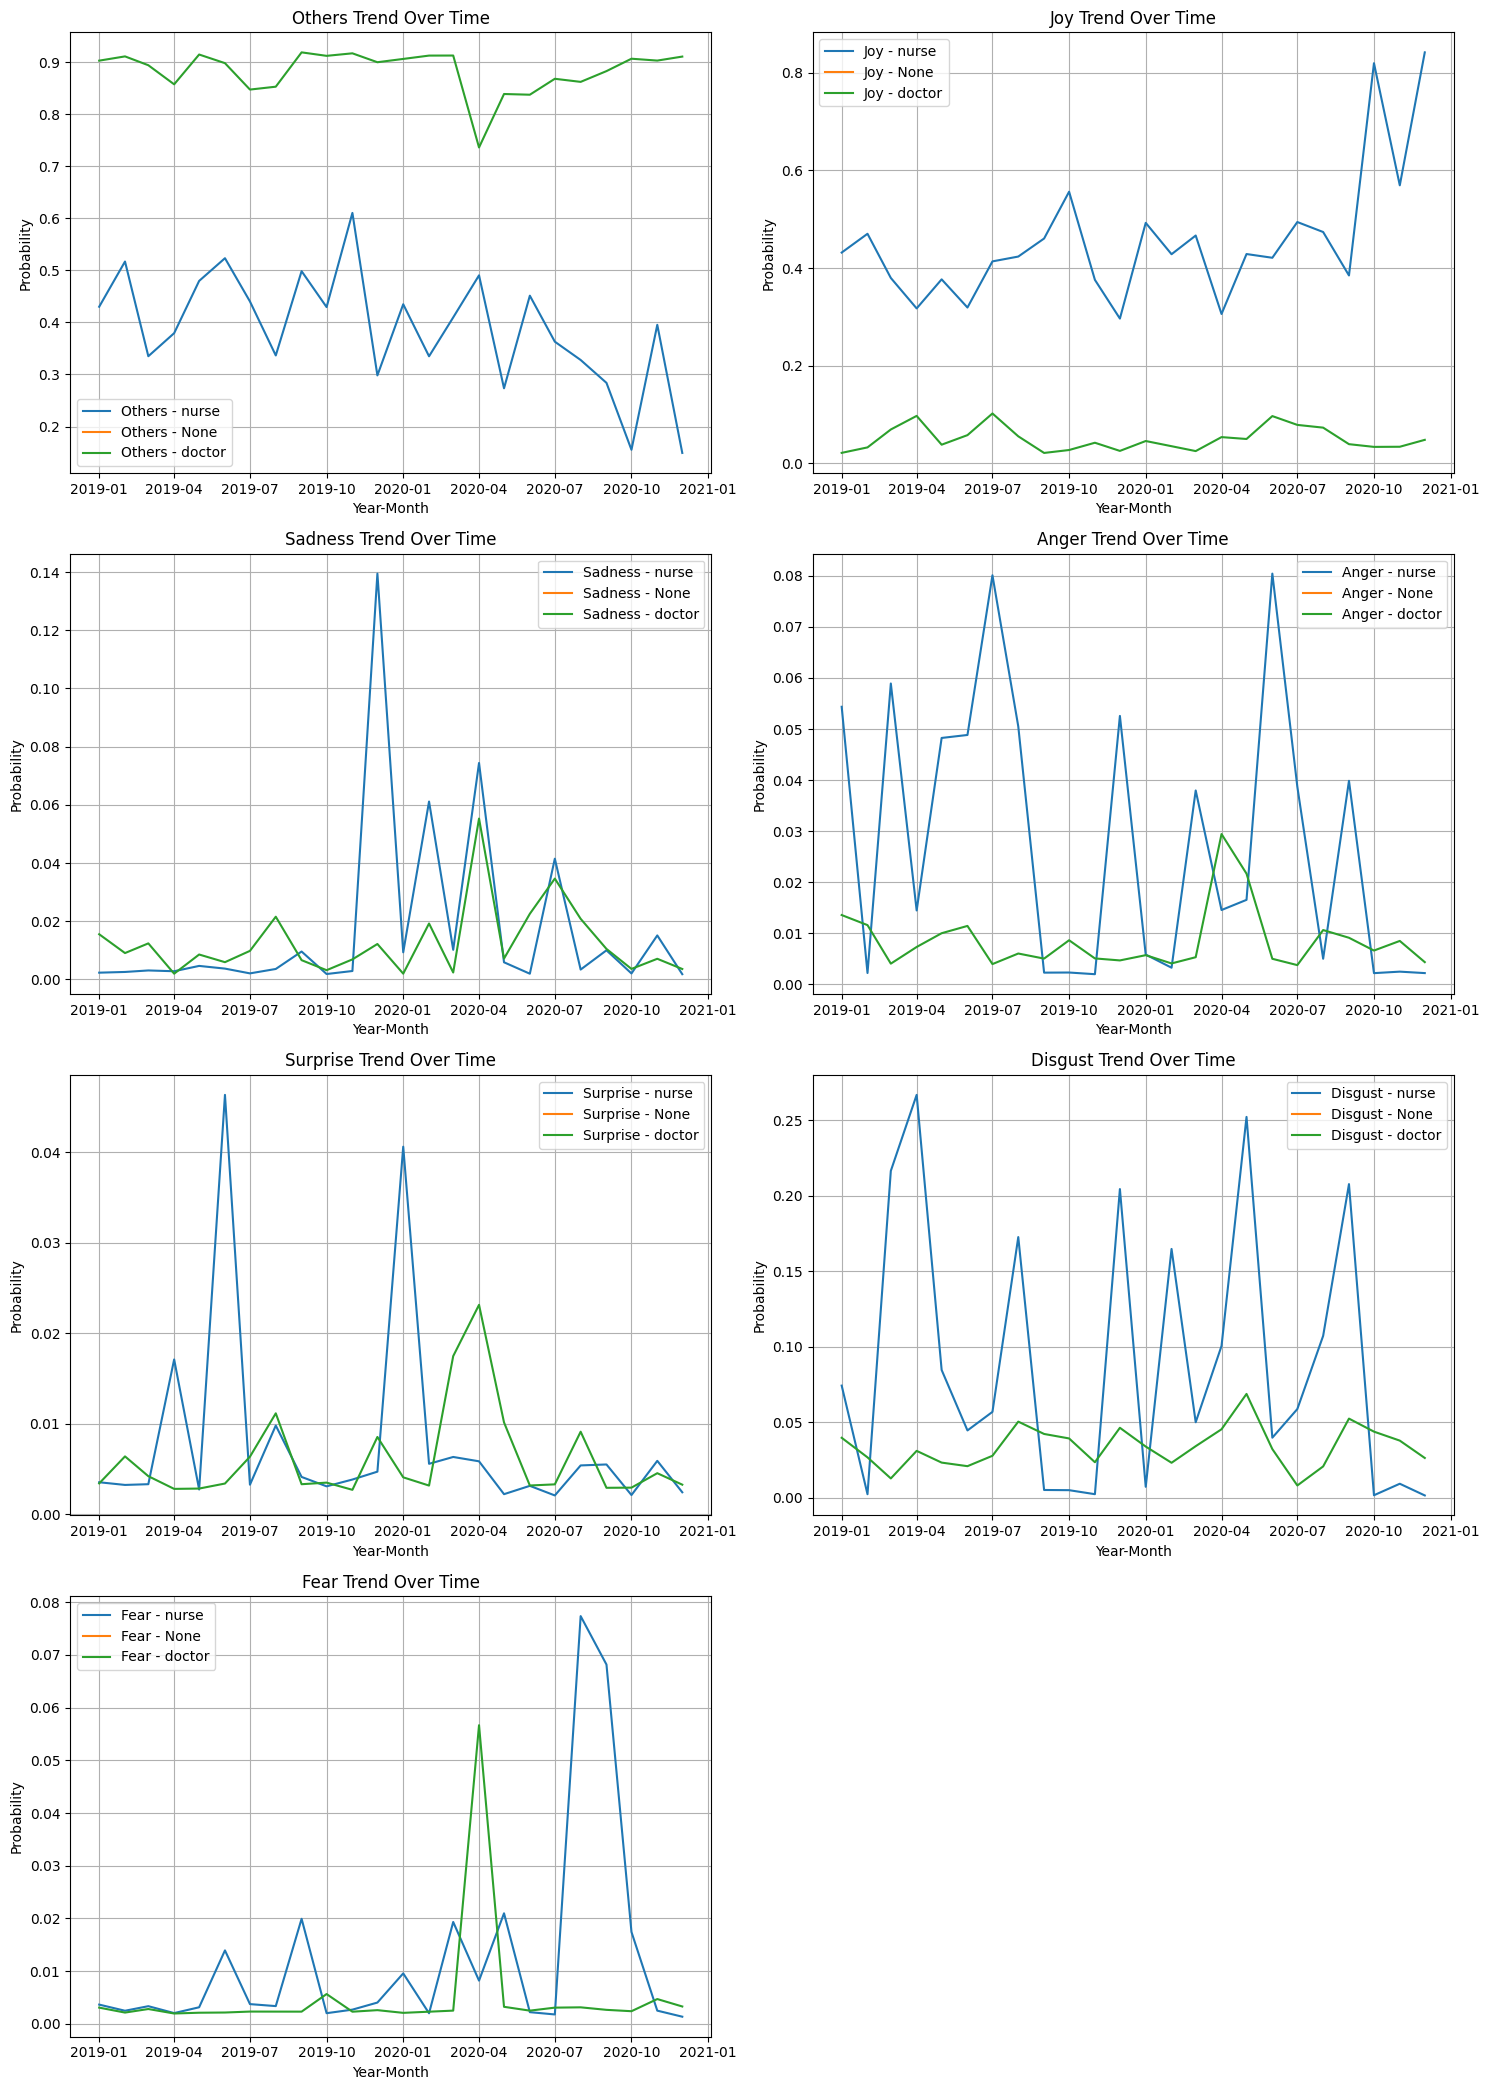

Processing and plotting results for sentiment...


/tmp/ipykernel_2620818/658242755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_date'] = pd.to_datetime(df['new_date'])
/tmp/ipykernel_2620818/658242755.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['new_date'].dt.to_period('M')
/tmp/ipykernel_2620818/658242755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Plot saved as: output_analysis2/sentiment_analysis_graphs/trends_plot.png


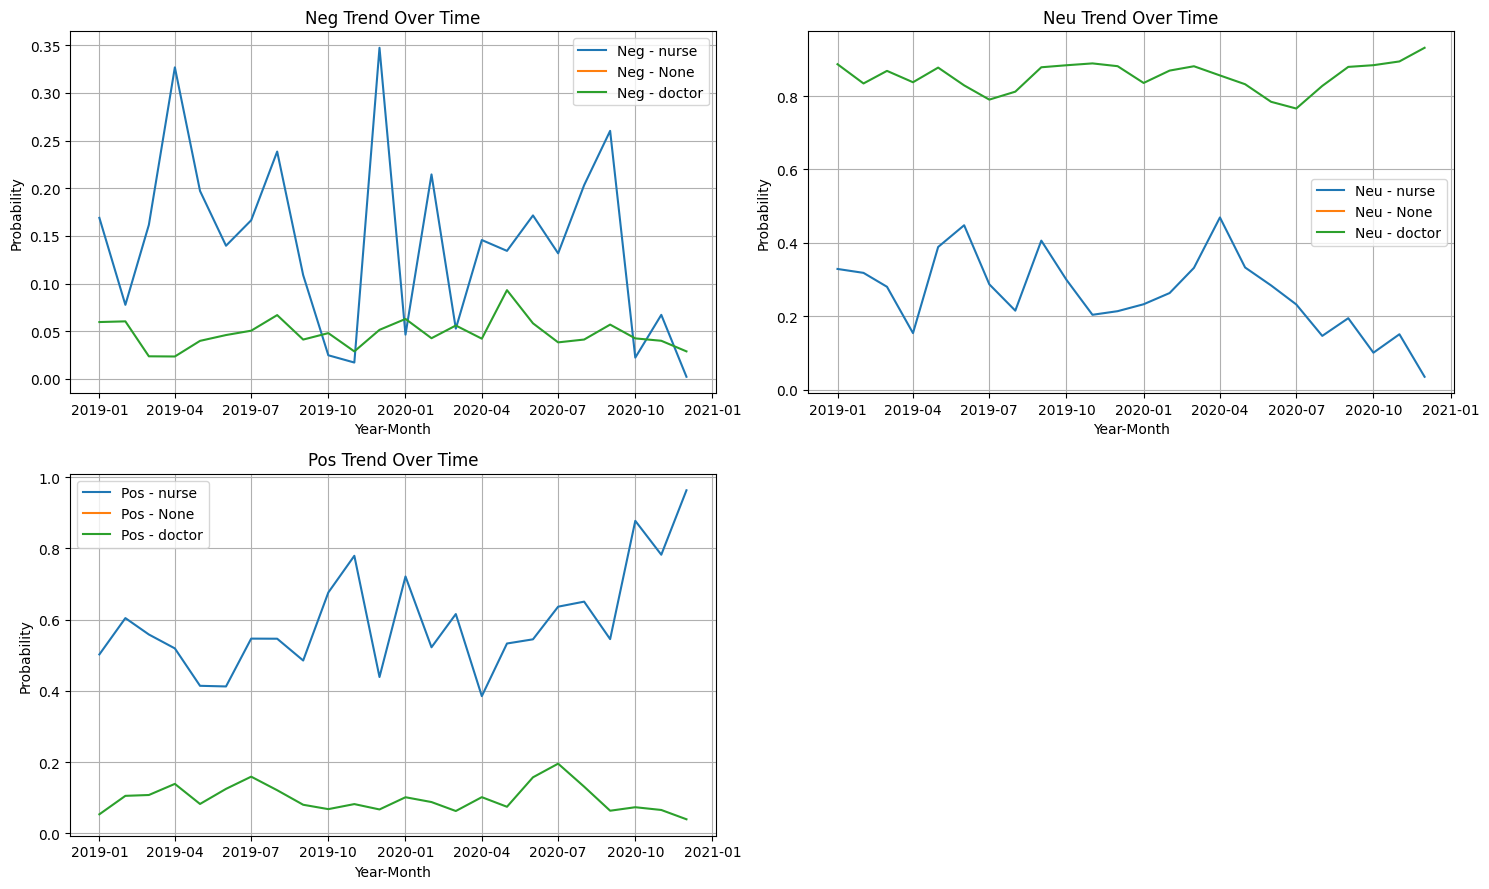

Processing and plotting results for hate_speech...


/tmp/ipykernel_2620818/658242755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_date'] = pd.to_datetime(df['new_date'])
/tmp/ipykernel_2620818/658242755.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_month'] = df['new_date'].dt.to_period('M')
/tmp/ipykernel_2620818/658242755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Plot saved as: output_analysis2/hate_speech_analysis_graphs/trends_plot.png


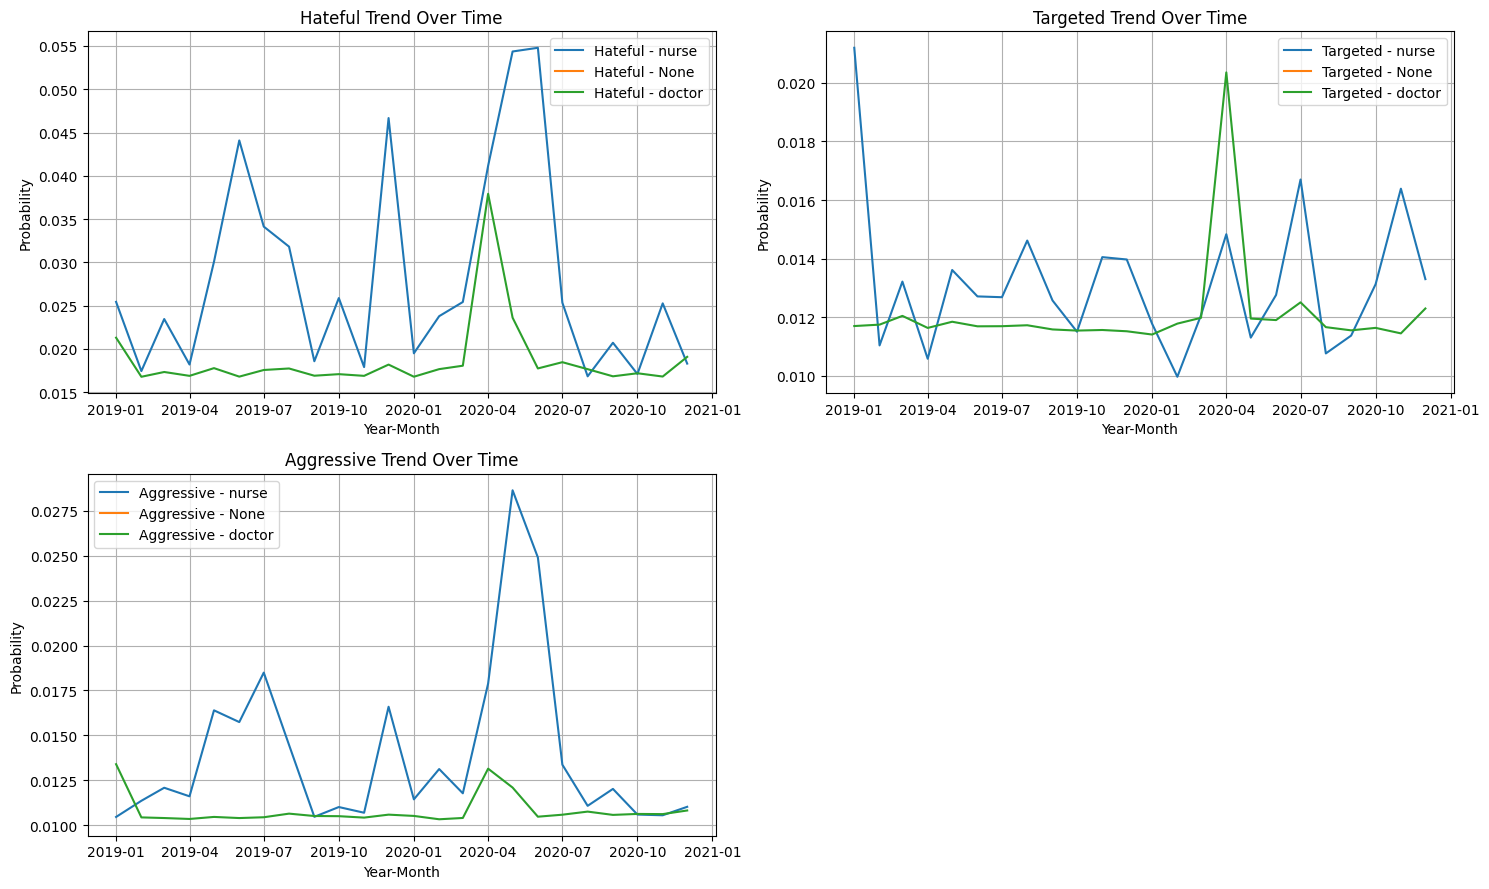

All outputs saved in: output_analysis2


In [23]:
import os
import pandas as pd

# Main function to load data, preprocess, analyze multiple tasks, and plot
def main(db_path, save_dir="output_analysis2", batch_size=1000, max_batches=10):
    os.makedirs(save_dir, exist_ok=True)

    # Load data from the database
    print("Loading data from database...")
    tweets_df, authors_df = load_data(db_path)

    # Preprocess the data
    print("Preprocessing data...")
    tweets_df = preprocess_data(tweets_df, authors_df)
    
    # Clean text data in 'content' column
    print("Cleaning text data...")
    tweets_df['content'] = tweets_df['content'].apply(clean_text)

    # Handle date parsing
    print("Parsing dates...")
    if 'date' not in tweets_df.columns or tweets_df['date'].isnull().all():
        raise ValueError("The 'date' column is missing or entirely null in the tweets dataframe.")
    
    tweets_df['new_date'] = tweets_df['date'].apply(lambda t: str(t).split(' ')[0])  # Extract the date part
    tweets_df['new_date'] = tweets_df['new_date'].apply(parse_date)  # Parse the date
    
    # Tasks to process
    tasks = ['emotion', 'sentiment', 'hate_speech']
    results_all_tasks = {}

    # Process tweets for each task
    for task in tasks:
        print(f"Processing tweets for {task}...")

        # Define task-specific output files
        task_output_file = os.path.join(save_dir, f"{task}_results.tsv")
        task_checkpoint_file = os.path.join(save_dir, f"{task}_checkpoint.pkl")

        # Process and save task-specific results
        process_tweets(tweets_df, task_output_file, task_checkpoint_file, batch_size, max_batches, lang="en", task=task)

        # Analyze task results
        print(f"Analyzing {task}...")
        task_results = pd.read_csv(task_output_file, sep='\t')  # Load processed task results
        results_all_tasks[task] = task_results

    # Calculate mean probabilities over time for each task and plot
    group_names = authors_df['label'].unique().tolist()  # Assuming 'label' column in authors table for social groups

    for task, task_results in results_all_tasks.items():
        print(f"Processing and plotting results for {task}...")
    
        # Dynamically handle task-specific columns
        task_columns = [col for col in task_results.columns if col not in ['author', 'new_date', 'content']]
    
        # Calculate monthly means per author first
        task_group_results = []
        for group_name in group_names:
            # Filter authors for the current group
            group_authors = authors_df[authors_df['label'] == group_name]['author_screen_name']
            group_data = task_results[task_results['author'].isin(group_authors)]
            
            # Calculate monthly means per author
            monthly_author_means = calculate_monthly_author_means(group_data, task_columns)
            
            # Calculate mean of means across all authors in the group
            group_means = calculate_mean_of_means(monthly_author_means, task_columns)
            task_group_results.append(group_means)
        
        # Save plots for the current task
        task_graph_output = os.path.join(save_dir, f"{task}_analysis_graphs")
        plot_trends(task_group_results, task_columns, group_names, task_graph_output)

    print(f"All outputs saved in: {save_dir}")



# Example usage
if __name__ == "__main__":
    db_path = "53k_individual_hcps_70_percent_confidence_tweets_2019_2022.db"
    main(db_path)
